In [1]:
from path import Path
from fastai.vision import *
import numpy as np
import pandas as pd
from PIL import Image
import json
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler


from ipywidgets import IntProgress
from IPython.display import display
import time


from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

from torchvision.models import inception_v3 as inception

In [2]:
path = Path('/home/jupyter/kaggle/imagenet_localization/data')

In [3]:
path.ls()

[PosixPath('/home/jupyter/kaggle/imagenet_localization/data/models'),
 PosixPath('/home/jupyter/kaggle/imagenet_localization/data/val.verify.pkl'),
 PosixPath('/home/jupyter/kaggle/imagenet_localization/data/val.pkl'),
 PosixPath('/home/jupyter/kaggle/imagenet_localization/data/LOC_val_solution.csv'),
 PosixPath('/home/jupyter/kaggle/imagenet_localization/data/train.verify.pkl'),
 PosixPath('/home/jupyter/kaggle/imagenet_localization/data/ILSVRC'),
 PosixPath('/home/jupyter/kaggle/imagenet_localization/data/train.csv'),
 PosixPath('/home/jupyter/kaggle/imagenet_localization/data/LOC_sample_submission.csv'),
 PosixPath('/home/jupyter/kaggle/imagenet_localization/data/LOC_train_solution.csv'),
 PosixPath('/home/jupyter/kaggle/imagenet_localization/data/LOC_synset_mapping.txt'),
 PosixPath('/home/jupyter/kaggle/imagenet_localization/data/data.sh'),
 PosixPath('/home/jupyter/kaggle/imagenet_localization/data/train.pkl'),
 PosixPath('/home/jupyter/kaggle/imagenet_localization/data/val.csv')

## Data Formatting
The following cells read in the raw data and convert to dataframe in a format readable by the fastai dataloader and only need to be run once

In [4]:
#convert synset mapping into dataframe

synset_mapping = {}
with open(path/'LOC_synset_mapping.txt') as f:
    for line in f:
        synset_id = line.split(" ")[0]
        literal_id = line.split(synset_id)[1].strip()
        synset_mapping[synset_id] = literal_id
df_synset = pd.DataFrame(data=synset_mapping.values(), index=synset_mapping.keys(), columns=['wnid'])
df_synset = df_synset.reset_index().rename(columns={'index':'id'})
df_synset['class'] = df_synset.index + 1
df_synset['class_literal'] = df_synset['wnid'].str.split(",").str[0]

In [5]:
##read in training annotations to dataframe

# data_path = 'ILSVRC/Data/CLS-LOC/'
# df_train_solution = pd.read_csv(path/'LOC_train_solution.csv')
# s_filename = data_path + "train/" + df_train_solution.ImageId.str.split("_").str[0] + \
#              "/" + df_train_solution.ImageId + '.JPEG'

In [6]:
##build list of classes and bboxes by image
##s_synclasses = [[image0_class0, image0_class1,...], [image1_class0], ...]
##s_bboxes = [[image0_y_max, image0_x_min, image0_y_min, image0_x_max], ...]

# s_synclasses = []
# s_bboxes = []
# for idx, row in tqdm(df_train_solution.PredictionString.str.strip().str.split(" ").iteritems(), total=len(df_train_solution)):
#     num_boxes = len(row) // 5
#     synset_ids = [row[i * 5] for i in range(num_boxes)]
#     synset_classes = [df_synset.loc[df_synset.id == synset_id]['class'].iloc[0] for synset_id in synset_ids]
#     bboxes = [[int(row[4 + j*5]), int(row[1 + j*5]), int(row[2 + j*5]), int(row[3 + j*5])] for j in range(num_boxes)]
#     s_synclasses.append(synset_classes)
#     s_bboxes.append(bboxes)

In [7]:
##convert lists to dataframe and save to pickle

# df_train_solution['classes'] = pd.Series(index=df_train_solution.index, data=s_synclasses)
# df_train_solution['bboxes'] = pd.Series(index=df_train_solution.index, data=s_bboxes)
# df_train_solution['image'] = s_filename
# df_train_solution[['image', 'bboxes', 'classes']].to_pickle(path/'train.pkl')

In [8]:
##read in validation annotations to dataframe

# df_val_solution = pd.read_csv(path/'LOC_val_solution.csv')
# s_filename = data_path + "val/" + df_val_solution.ImageId + '.JPEG'

In [9]:
##build list of classes and bboxes by image
##s_synclasses = [[image0_class0, image0_class1,...], [image1_class0], ...]
##s_bboxes = [[image0_y_max, image0_x_min, image0_y_min, image0_x_max], ...]

# s_synclasses = []
# s_bboxes = []
# for idx, row in tqdm(df_val_solution.PredictionString.str.strip().str.split(" ").iteritems(), total=len(df_val_solution)):
#     num_boxes = len(row) // 5
#     synset_ids = [row[i * 5] for i in range(num_boxes)]
#     synset_classes = [df_synset.loc[df_synset.id == synset_id]['class'].iloc[0] for synset_id in synset_ids]
#     bboxes = [[int(row[4 + j*5]), int(row[1 + j*5]), int(row[2 + j*5]), int(row[3 + j*5])] for j in range(num_boxes)]
#     s_synclasses.append(synset_classes)
#     s_bboxes.append(bboxes)

In [10]:
##convert lists to dataframe and save to pickle

# df_val_solution['classes'] = pd.Series(index=df_val_solution.index, data=s_synclasses)
# df_val_solution['bboxes'] = pd.Series(index=df_val_solution.index, data=s_bboxes)
# df_val_solution['image'] = s_filename
# df_val_solution[['image', 'bboxes', 'classes']].to_pickle(path/'val.pkl')

In [11]:
# df_train  = pd.read_pickle(path/'train.pkl')
# df_val = pd.read_pickle(path/'val.pkl')

In [12]:
def verify_image_df(path, df):
    """Takes a path and dataframe and verifies all image files in the 'image' column
       Returns a list of invalid indices
    """
    bad_idx = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        try:
            with PIL.Image.open(path/row['image']) as test:
                pass
        except Exception as e:
            bad_idx.append(idx)
    return bad_idx

## Data cleaning
Verify that all images in the training and validation set are able to be opened and exclude those that aren't

In [13]:
#bad_idx_train = verify_image_df(path, df_train)

In [14]:
#bad_idx_valid = verify_image_df(path, df_val)

In [15]:
# df_train.loc[~df_train.index.isin(bad_idx_train)].to_pickle(path/'train.verify.pkl')
# df_val.loc[~df_val.index.isin(bad_idx_valid)].to_pickle(path/'val.verify.pkl')

In [16]:
df_train  = pd.read_pickle(path/'train.verify.pkl')
df_val = pd.read_pickle(path/'val.verify.pkl')

In [17]:
df_train.head()

,image,bboxes,classes
0,ILSVRC/Data/CLS-LOC/train/n02017213/n02017213_...,"[[294, 115, 49, 448]]",[137]
1,ILSVRC/Data/CLS-LOC/train/n02017213/n02017213_...,"[[432, 91, 42, 330]]",[137]
2,ILSVRC/Data/CLS-LOC/train/n02017213/n02017213_...,"[[224, 230, 104, 414]]",[137]
3,ILSVRC/Data/CLS-LOC/train/n02017213/n02017213_...,"[[387, 46, 82, 464]]",[137]
4,ILSVRC/Data/CLS-LOC/train/n02017213/n02017213_...,"[[335, 103, 66, 331]]",[137]


In [18]:
df_val.head()

,image,bboxes,classes
0,ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_0004898...,"[[272, 85, 1, 499]]",[741]
1,ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_0003795...,"[[254, 131, 0, 499]]",[588]
2,ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_0002616...,"[[280, 38, 0, 464]]",[242]
3,ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_0002617...,"[[299, 0, 14, 216]]",[513]
4,ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_0000872...,"[[329, 255, 142, 454], [295, 44, 21, 322]]","[279, 279]"


## Data Loading
The fastai data loader takes one dataframe of both training and validation data distinguished by a flag. Concatenate the data and take a sample of a smaller subset if testing the model.

For object detection datasets with bounding boxes, we must inform the data loader how to label the data. We do this with a simple lambda function that looks up (bounding box, class) in a dictionary keyed on image path.

Verify that a batch of the images with their bounding boxes looks sane.

In [19]:
df_train['train_valid'] = 0
df_val['train_valid'] = 1
#df_concat = pd.concat([df_train.sample(200000), df_val.sample(40000)])
df_concat = pd.concat([df_train, df_val])
cols = ['file_name', 'category_id', 'train_valid']

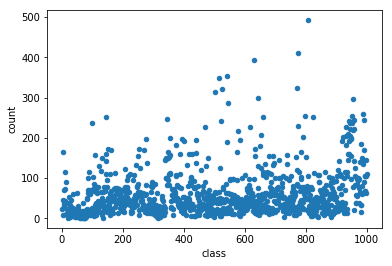

In [20]:
df_classes = pd.DataFrame(df_concat.classes.tolist()).groupby(0).count().reset_index()
df_classes = df_classes.rename(columns={0:'class', 1:'count'})[['class', 'count']]
df_classes.plot(x='class', y='count', kind='scatter')

In [21]:
#get top n classes (for initial testing purposes)
top_n = 50
df_concat = df_concat.set_index('image')
s_concat_class = pd.DataFrame(df_concat.classes.tolist(), index=df_concat.index).rename(columns={0:'class'})[['class']]
s_classes_sort = df_classes.sort_values('count', ascending=False)
concat_idx = s_concat_class.loc[s_concat_class['class'].isin(s_classes_sort.iloc[:top_n]['class'])].index
df_concat = df_concat.loc[concat_idx].reset_index()

In [22]:
x = [list(x) for x in zip(df_concat.bboxes, df_concat.classes)]
img2bbox = dict(zip(df_concat.image, x))
get_y_func = lambda o:img2bbox[o.replace(str(path) + "/", "")]

In [55]:
data = None
gc.collect()

model = models.resnet34
sz = 224
bs = 16

tfms = get_transforms(do_flip=True, flip_vert=False)
data = (ObjectItemList.from_df(df_concat, path=path)
        .split_from_df(col=3)
        .label_from_func(get_y_func)
        .transform(tfms, tfm_y=True, size=(sz, sz))
        .databunch(bs=bs, collate_fn=bb_pad_collate)
        .normalize(imagenet_stats)
       )

#hack to fixed inexplicable bug in data loader where valid_ds categories are None despite being valid
for i,valid_y in enumerate(data.valid_ds.y.items):
    if valid_y[1][0] == None:
        data.valid_ds.y.items[i] = get_y_func(data.valid_ds.x.items[i])
        
#assign literal class values to data
s_class_literal = df_synset.set_index('class').loc[data.classes]['class_literal']
data.classes = list(s_class_literal.fillna('background').values)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


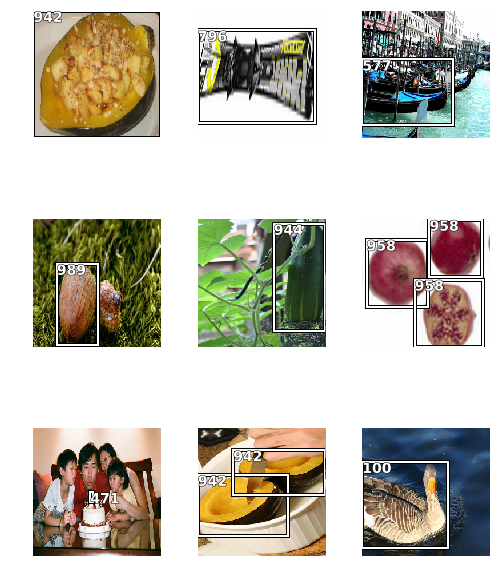

In [24]:
data.show_batch(rows=3, figsize=(7, 9))

## Model
Below we define the model that we are going to use. Since this is not a straightforward categorization task, we need to add additional layers to the standard Resnet34 CNN.

First we define a standard convolution (StdConv) as a stride 2, 3x3 convolution followed by ReLu, Batch Normalization and Dropout. Next, we define a helper function to flatten the convolution....more info to come. We then define OutConv--the specific model we'll be using to handle single shot multiple object detection. OutConv is defined by two parallel convolution layers that take the final number of features from the Resnet34 (possibly passed through another convolution or two) as their number of inputs. One layer computes a convolution with number of output features equal to the total number of object classes plus one for background. The other layer outputs 4 features for the 4 coordinates necessary to define a bounding box. We pass those outputs to flatten_convolution and return both.

SSD_Head defines the model that we stitch onto the head of the Resnet34. We take the output from Resnet34 of size 512, apply ReLu and Dropout and pass that through a stride 1 StdConv yielding us 256 features, pass that through a stride 2 StdConv yielding us 256 features and finally pass that output through OutConv yielding us two separate arrays. One defining the class probabilities and one defining the bounding box.

In [25]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, dropout=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(dropout)
    def forward(self, x):
        return self.drop(self.bn(F.relu(self.conv(x))))
    
def flatten_conv(x, k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs, -1, nf//k)

class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, data.c * k, 3, padding=1)
        self.oconv2 = nn.Conv2d(nin, 4*k, 3, padding=1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k), flatten_conv(self.oconv2(x), self.k)]
    
class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(.25)
        self.sconv0 = StdConv(512, 256, stride=1)
        self.sconv1 = StdConv(256, 256)
        self.out = OutConv(k, 256, bias)
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv1(x)
        return self.out(x)
    
k = 1
f_model = models.resnet34
head_reg4 = SSD_Head(k, -3.)
learn = cnn_learner(data, f_model, custom_head=head_reg4)

## Helper Functions
Below we define a variety of helper functions that we use at various steps in our process. Some are used for visualization to help us understand the process while others are used to compute the loss. Each function should have a docstring describing its usage and output.

In [26]:
###Define helper functions
def show_img(im, figsize=None, ax=None):
    """Standard func to display image
    """
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def bb_hw(a): 
    """Reshapes bounding box from bottom left (x,y), top right (x,y) to
       bottom left y, bottom left x, height, width
    """
    return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

def draw_outline(o, lw):
    """Adds black border around line
    """
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    """Draws bounding rectangle
    """
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)
    
def draw_text(ax, xy, txt, sz=14, color='white'):
    """Draws text inside bounding rectangle
    """
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def get_cmap(N):
    """Gets colors
    """
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3, ignore_bg=False):
    """Given ax, image, list of bboxes, list of classes, list of probabilities and threshold
       Displays image with ground truth broxes
    """
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if c == 0 and ignore_bg:
            continue
        if((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += str('bg' if c==0 else data.classes[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.3, ignore_bg=False):
    """Show ground truth given image and torch bbox
    """
    return show_ground_truth(ax, ima, to_np((bbox*224).long()),
         to_np(clas), to_np(prs) if prs is not None else None, thresh, ignore_bg=ignore_bg)

def get_y(bbox:torch.tensor, clas:torch.tensor):
    """Returns tensor with 0 rows removed
    """
    if len(bbox.shape) == 1:
        bbox.unsqueeze_(0)
    bbox = (bbox + 1.) / 2.
    idx_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return bbox[idx_keep], clas[idx_keep]

def hw2corners(ctr, hw): 
    """Converts array of x,y and height,width to top-left, bottom-right
    """
    return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

def actn_to_bb(actn, anchors):
    """Mapping activation to anchor boxes
    """
    actn_bbs = torch.tanh(actn) #map activations to [-1,1]
    actn_centers = ((actn_bbs[:, :2]/2).float() * grid_sizes.cuda().float()) + anchors[:,:2].cuda().float() #center relative to anchor box
    actn_hw = ((actn_bbs[:, 2:]/2).float() + 1) * anchors[:,2:].cuda().float() #get height and width relative to anchor box
    return hw2corners(actn_centers, actn_hw)

def intersection(box_a, box_b):
    """Computes intersection between two boxes
    """
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b):
    """Computes box size of b
    """
    return (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1]) #height x width

def jaccard(box_a, box_b):
    """Computes jaccard distance between two boxes
    """
    box_a = box_a.cuda().float()
    box_b = box_b.cuda().float()
    inter = intersection(box_a, box_b)
    union = (box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter)
    return inter/union

def map_to_ground_truth(overlaps, verbose=False):
    """Takes an array of IOU overlaps between anchor boxes and the ground truth bounding boxes
       Yields an array of overlaps by anchor box and indices of the class with which the anchor box overlaps
    """
    prior_overlap, prior_idx = overlaps.max(1)
    if verbose: print(prior_overlap)
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap, gt_idx

def one_hot_embedding(labels, num_classes):
    """Returns a one hot embedded matrix
    """
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    """Binary cross entropy loss
    """
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        
    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes)
        t = t[:,:-1].contiguous()
        x = pred[:, :-1].cpu()
        w = self.get_weight(x, t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
    def get_weight(self, x, t):
        return None

## Visualizing the model
The set of cells that follow help us to visualize the process by which the anchor boxes, ground truth boxes and ultimately the model functions.

We run our randomly weighted model against a single batch and produce a batch of a predictions. We arbitrarily index into this batch and analyze the results of a single image. The predicted output is an array of classes (16x1) and bounding boxes (16x4) by anchor box for the specified image.

In [27]:
# specify the arbitrary image index and get the x and y (ground truth) batch
idx = 6
x,y = next(iter(data.valid_dl))

In [28]:
y[0][idx].view(-1, 4), y[1][idx], [data.classes[i] for i in to_np(y[1][idx]) if i > 0]

(tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [-0.6560, -0.8198,  0.7640,  0.7357]], device='cuda:0'),
 tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 22], device='cuda:0'),
 ['mitten'])

In [29]:
# predict on the batch
learn.model.eval()
batch = learn.model(x)
b_clas,b_bb = batch

In [30]:
b_clasi = b_clas[idx] #class prediction for the image
b_bbi = b_bb[idx].float() #bounding box prediction for the image

In [31]:
# denormalize the image before plotting
mean = torch.tensor(imagenet_stats[0])
std = torch.tensor(imagenet_stats[1])
ima = to_np(denormalize(x, mean, std)[idx].permute(1,2,0))


In [32]:
# trim off rows of all 0s 
bbox, clas = get_y(y[0][idx], y[1][idx])

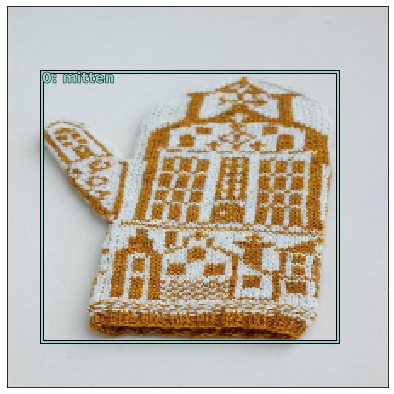

In [33]:
# visualizing the ground truth image and classes and BBs
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, bbox, clas)

## Visualizing the model
In the following cells we visualize the center of the anchor boxes on a blank plot, the anchor boxes with their class prediction on the image, and finally the anchor boxes with their predicted bounding boxes.

In [34]:
#generating 16 ABs
anc_grid = 4
k = 1 #number of possible combinations of ABs we are producing

anc_offset = 1/(anc_grid*2)
# X coords of center of ABs
anc_x = np.repeat(np.linspace(anc_offset, 1 - anc_offset, anc_grid), anc_grid)

# Y coords of center of ABs
anc_y = np.tile(np.linspace(anc_offset, 1 - anc_offset, anc_grid), anc_grid)

# putting X and Y ctrs together
anc_ctrs = np.tile(np.stack([anc_x, anc_y], axis=1), (k, 1))
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid*k)])
anchors = torch.tensor(np.concatenate([anc_ctrs, anc_sizes], axis=1))
grid_sizes = torch.tensor(np.array([1/anc_grid])).unsqueeze(1)

(0, 1)

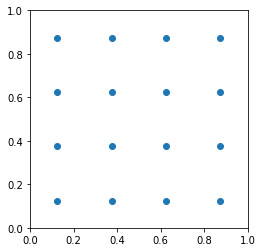

In [35]:
# plot the center of the 16 anchor boxes
fig2 = plt.figure()
ax2 = fig2.add_subplot(111, aspect='equal')
plt.scatter(anc_x, anc_y)
plt.xlim(0, 1)
plt.ylim(0, 1)

In [36]:
#convert boxes into corners (top-left, bottom-right)
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])

In [37]:
#class assigned to each AB (highest probability)
["AB {0}; class ID {1}; class {2}".format(i+1, j, 'bg' if j==data.c else data.classes[j]) for i, j in enumerate(to_np(b_clasi.max(1)[1]))]
 

['AB 1; class ID 42; class orange',
 'AB 2; class ID 17; class hair slide',
 'AB 3; class ID 30; class street sign',
 'AB 4; class ID 43; class lemon',
 'AB 5; class ID 21; class military uniform',
 'AB 6; class ID 17; class hair slide',
 'AB 7; class ID 17; class hair slide',
 'AB 8; class ID 17; class hair slide',
 'AB 9; class ID 46; class jackfruit',
 'AB 10; class ID 17; class hair slide',
 'AB 11; class ID 17; class hair slide',
 'AB 12; class ID 17; class hair slide',
 'AB 13; class ID 46; class jackfruit',
 'AB 14; class ID 46; class jackfruit',
 'AB 15; class ID 10; class clog',
 'AB 16; class ID 17; class hair slide']

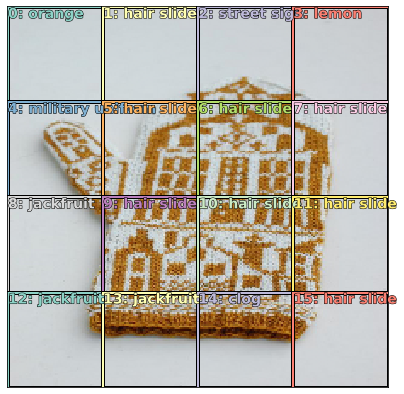

In [38]:
#visualizing ABs with class prediction for the part they're responsible for
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, anchor_cnr, b_clasi.max(1)[1])

## Visualizing the model
The process by which we re-center and adjust the bounding box to its corresponding anchor box is critical to understanding the model.

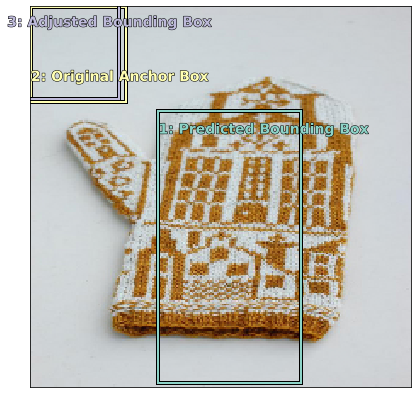

In [39]:
a_ic = actn_to_bb(b_bbi, anchors.float())

#slightly modified show_ground_truth to visualize actn_to_bb
def show_ground_truth2(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    """Displays anchor box, predicted activation and recentered activation
    """
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    k=0
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh)):
            k+=1
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{k}: '
            if isinstance(c, str):
                txt += c
            else:
                if c is not None: txt += str('bg' if c==0 else data.classes[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2] + np.array([0, np.random.randint(0, 40)]), txt, color=colr_list[i%num_colr])
            
#example with first AB act of batch
ab_idx = 0
bbo = torch.cat(((b_bbi[ab_idx,:] + 1) / 2, anchor_cnr[ab_idx, :].cuda().float(), a_ic[ab_idx, :]), 0).view(3,4)

# as you can see the ABAct (1) is far from the AB it is anchored to (2)
# we re-center it on 2 and alter its position/size
fig, ax = plt.subplots(figsize=(7,7))
show_ground_truth2(ax, ima, to_np((bbo*224).long()), ['Predicted Bounding Box', 'Original Anchor Box', 'Adjusted Bounding Box'])

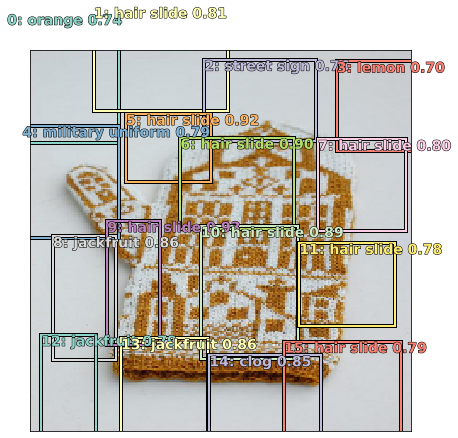

In [40]:
# this is the result after all ABAct have gone through AB re-centering
# and position/size alterations
fig, ax = plt.subplots(figsize=(7,7))
torch_gt(ax, ima, a_ic, b_clasi.max(1)[1], b_clasi.max(1)[0].sigmoid(), thresh=0.0)

## Computing the loss
In the following cells we build the process by which the final loss function will be computed. Specifically, we compute the Jaccard coefficient between the ground truth bounding boxes and each anchor box. We "assign" a ground truth bounding box and class to each anchor box from the ground truth bounding box it most overlaps with, provided the overlap is over a certain threshold. We now have a ground truth for each of the 16 anchor boxes. We diff the coordinates with those predicted for each anchor box to compute one loss and compute a Binary Cross Entropy loss between the predicted class and ground truth class for the other. The sum off these losses is what we attempt to minimize.

In [41]:
#overlapping ABs and ground truth BBs
#overlap is [num BBs] x 16
overlaps = jaccard(bbox.data, anchor_cnr.data)

In [42]:
overlaps

tensor([[0.0207, 0.0328, 0.0328, 0.0152, 0.0696, 0.1132, 0.1132, 0.0503, 0.0696,
         0.1132, 0.1132, 0.0503, 0.0356, 0.0567, 0.0567, 0.0260]],
       device='cuda:0')

In [43]:
gt_overlap, gt_idx = map_to_ground_truth(overlaps)
gt_clas = clas[gt_idx]

In [44]:
thresh = 0.4
pos = gt_overlap > thresh
pos_idx = torch.nonzero(pos)[:, 0]
neg_idx = torch.nonzero(1 - pos)[:, 0]

In [45]:
gt_clas[1-pos] = 0
[data.classes[o] if o > 0 else 'bg' for o in gt_clas]

['bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'mitten',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg']

In [46]:
gt_bbox = bbox[gt_idx]
loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
loss_f = BCE_Loss(data.c)
clas_loss = loss_f(b_clasi, gt_clas)
loc_loss, clas_loss

/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


(tensor(0.2205, device='cuda:0', grad_fn=<MeanBackward1>),
 tensor(12.1915, grad_fn=<DivBackward0>))

In [47]:
def ssd_1_loss(b_c, b_bb, bbox, clas, thresh=.4, verbose=False):
    """Computes loss for one image and set of bbox predictions
       Takes b_c and b_bb which are predicted classes and bounding boxes (output from NN)
       and bbox and clas which are ground truth bounding box and classes for image
    """
    bbox, clas = get_y(bbox, clas) #reformat gt bbox and gt clas
    if len(bbox) == 0: return 0, 0 #if there's no bbox, we can't use this in our loss
    a_ic = actn_to_bb(b_bb, anchors) #map activation b_bb to anchor points (defined above)
    overlaps = jaccard(bbox.data, anchor_cnr.data.cuda().float()) #get overlaps between gt bbox and anchor boxes
    gt_overlap, gt_idx = map_to_ground_truth(overlaps, verbose)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > thresh
    pos_idx = torch.nonzero(pos)[:, 0] #get indices of anchor boxes with sufficient overlap with GT
    gt_clas[1-pos] = 0 #assign background class
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean() #get average absolute loss between coordinates
    clas_loss = loss_f(b_c, gt_clas) #get cross entropy loss on predicted classes
    return loc_loss, clas_loss

def ssd_loss(pred, targ0, targ1, verbose=False):
    """For a batch of predictions and a batch of (targ0, targ1) where targ0 is ground truth bbox and
       targ1 is ground truth classes compute the loss. We do this by iterating over the batch and computing
       loss on each individual image and summing the results. I believe the losses must be placed on the CPU
       due to the way fastai is handling the loss function
    """
    lcs,lls=0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred, targ0, targ1):
        if len(bbox) == 0:
            continue
        loc_loss, clas_loss = ssd_1_loss(b_c, b_bb, bbox, clas, verbose=verbose)
        lls += loc_loss
        lcs += clas_loss
    if verbose:
        print("loc: {0}, clas: {1}".format(lls.data[0], lcs.data[0]))
    return lls.cpu() + lcs.cpu() #need to revisit why this is necessary

In [48]:
learn.loss_func = ssd_loss

In [119]:
#learn.lr_find()

In [120]:
#learn.recorder.plot()

In [121]:
learn.fit_one_cycle(5, max_lr=1e-5)

epoch,train_loss,valid_loss,time
0,683.124329,622.367432,03:39
1,307.193359,256.807465,03:42


KeyboardInterrupt: 

In [122]:
learn.save('stage-1')

In [58]:
# re-run predictions
learn.load('stage-1')
learn.model.eval()
batch = learn.model(x)
b_clas,b_bb = batch

/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type SSD_Head. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type StdConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type OutConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


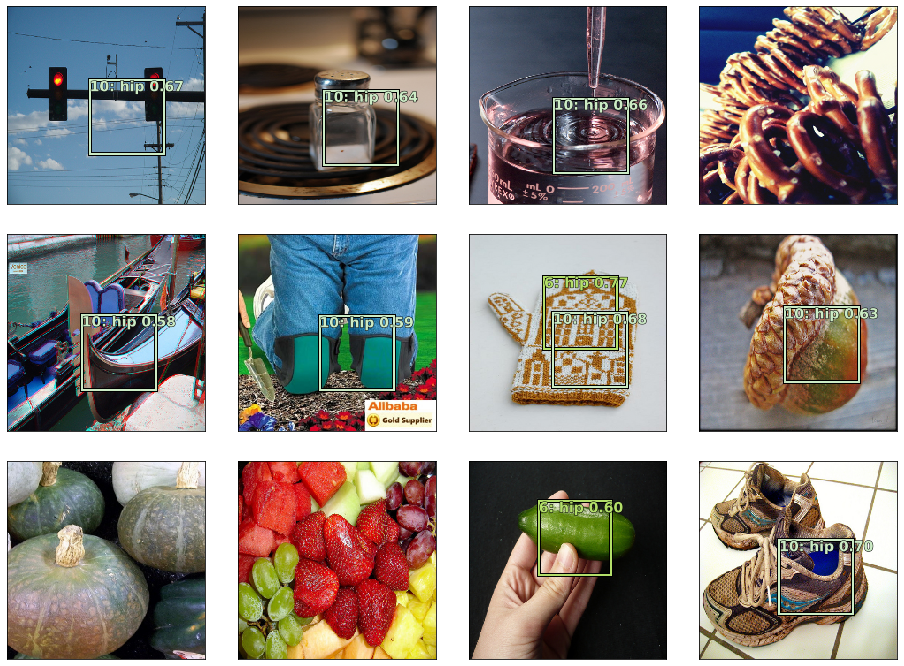

In [58]:
#let's visualize the the model after some training
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i, ax in enumerate(axes.flat):
    ima = to_np(denormalize(x, mean, std)[i].permute(1,2,0)) #denormalize x at idx and assign to ima var
    bbox,clas = get_y(y[0][i], y[1][i]) #get ground truth bbox and class
    a_ic = actn_to_bb(b_bb[i], anchors) #convert bounding box predictions into plottable format
    torch_gt(ax, ima, a_ic, b_clas[i].max(1)[1], b_clas[i].max(1)[0].sigmoid(), 0.01, ignore_bg=True)
 
plt.subplots_adjust(wspace=0.15, hspace=0.15)

In [56]:
anc_grids = [4, 2, 1] #this is a 4x4, 2x2 and 1x1 grid for a total of 16 + 4 + 1 = 21 points
anc_zooms = [0.7, 1., 1.3]
anc_ratios = [(1., 1.), (1., 0.5), (0.5, 1.)]
anchor_scales = [(anz*i, anz*j) for anz in anc_zooms for (i, j) in anc_ratios] #3 zooms and 3 ratios for a total of 9 combinations
k = len(anchor_scales)
anc_offsets = [1/(o*2) for o in anc_grids] #scale grids to  [0,1]
anc_x = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag) for ao,ag in zip(anc_offsets, anc_grids)]) #get 21 x points
anc_y = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag) for ao,ag in zip(anc_offsets, anc_grids)]) #get 21 y points
anc_ctrs = np.repeat(np.stack([anc_x, anc_y], axis=1), k, axis=0) #get 21 * 9 = 189 total (x,y) grid points
anc_sizes  =   np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales]) for ag in anc_grids])
grid_sizes = torch.tensor(np.concatenate([np.array([1/ag for i in range(ag*ag) for o,p in anchor_scales])for ag in anc_grids])).unsqueeze(1)
anchors = torch.tensor(np.concatenate([anc_ctrs, anc_sizes], axis=1))
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])

(0, 1)

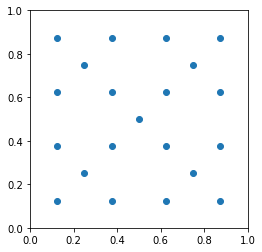

In [57]:
# plot the center of the 21 anchor boxes (189 after zooming and stretching)
fig2 = plt.figure()
ax2 = fig2.add_subplot(111, aspect='equal')
plt.scatter(anc_x, anc_y)
plt.xlim(0, 1)
plt.ylim(0, 1)

In [58]:
##Modify the model to handle the change
class SSD_MultiHead(nn.Module):
    def __init__(self, k, bias, dropout=.25):
        super().__init__()
        self.drop = nn.Dropout(dropout)
        self.sconv0 = StdConv(512, 256, stride=1, dropout=dropout)
        self.sconv1 = StdConv(256, 256, dropout=dropout)
        self.sconv2 = StdConv(256, 256, dropout=dropout)
        self.sconv3 = StdConv(256, 256, dropout=dropout)
        self.out1 = OutConv(k, 256, bias)
        self.out2 = OutConv(k, 256, bias)
        self.out3 = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
        x = self.sconv1(x)
        o1c,o1l = self.out1(x)
        x = self.sconv2(x)
        o2c,o2l = self.out2(x)
        x = self.sconv3(x)
        o3c,o3l = self.out3(x)
        return [torch.cat([o1c, o2c, o3c], dim=1),
                torch.cat([o1l, o2l, o3l], dim=1)]
    
dropout=0.4
head_reg4 = SSD_MultiHead(k, -4, dropout)
learn = cnn_learner(data, f_model, custom_head=head_reg4)

In [59]:
z = torch.randn(bs, 512, 7 ,7).cuda() #set z as output of resnet34 that will be fed into head
z = head_reg4.drop(F.relu(z))
z = head_reg4.sconv0(z); print("Shape after first conv:", z.shape)
z = head_reg4.sconv1(z); print("Shape after second conv:", z.shape)
o1c,o1l = head_reg4.out1(z); print("Shape of first outconv output:", o1c.shape, o1l.shape)
z = head_reg4.sconv2(z); print("Shape after third conv:", z.shape)
o2c,o2l = head_reg4.out2(z); print("Shape of second outconv output:", o2c.shape, o2l.shape)
z = head_reg4.sconv3(z); print("Shape after fourth conv:", z.shape)
o3c,o3l = head_reg4.out3(z); print("Shape of third outconv output:", o3c.shape, o3l.shape)
print("Shape of final output:",torch.cat([o1c, o2c, o3c], dim=1).shape, torch.cat([o1l, o2l, o3l], dim=1).shape)

Shape after first conv: torch.Size([16, 256, 7, 7])
Shape after second conv: torch.Size([16, 256, 4, 4])
Shape of first outconv output: torch.Size([16, 144, 51]) torch.Size([16, 144, 4])
Shape after third conv: torch.Size([16, 256, 2, 2])
Shape of second outconv output: torch.Size([16, 36, 51]) torch.Size([16, 36, 4])
Shape after fourth conv: torch.Size([16, 256, 1, 1])
Shape of third outconv output: torch.Size([16, 9, 51]) torch.Size([16, 9, 4])
Shape of final output: torch.Size([16, 189, 51]) torch.Size([16, 189, 4])


In [60]:
learn.loss_func = ssd_loss

In [61]:
learn.fit_one_cycle(2, max_lr=1e-5)

epoch,train_loss,valid_loss,time
0,806.526001,684.461792,08:41
1,373.663727,315.252686,07:03


/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [62]:
learn.save('stage-2')

In [63]:
# re-run predictions
learn.load('stage-2')
learn.model.eval()

x,y = next(iter(data.valid_dl))
batch = learn.model(x)
b_clas,b_bb = batch

/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type SSD_MultiHead. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type StdConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type OutConv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


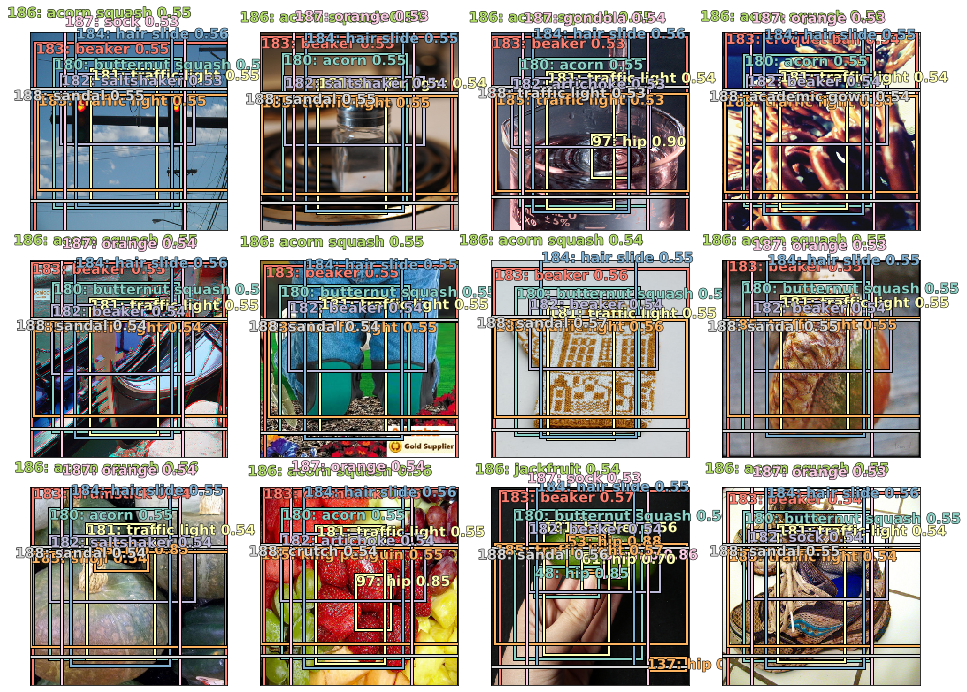

In [64]:
#let's visualize the the model after some training
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
for i, ax in enumerate(axes.flat):
    ima = to_np(denormalize(x, mean, std)[i].permute(1,2,0)) #denormalize x at idx and assign to ima var
    bbox,clas = get_y(y[0][i], y[1][i]) #get ground truth bbox and class
    a_ic = actn_to_bb(b_bb[i], anchors) #convert bounding box predictions into plottable format
    torch_gt(ax, ima, a_ic, b_clas[i].max(1)[1], b_clas[i].max(1)[0].sigmoid(), thresh=.1, ignore_bg=True)
 
plt.subplots_adjust(wspace=0.15, hspace=0.15)